In [ ]:
#!pip install kaggle

In [ ]:
#from google.colab import files
#files.upload()  # Bu komut, kaggle.json dosyasını yüklemenizi sağlar.

In [ ]:
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#pip install imbalanced-learn


In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 91% 60.0M/66.0M [00:00<00:00, 226MB/s]
100% 66.0M/66.0M [00:00<00:00, 205MB/s]


In [6]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


# **Introduction**
Kredi kartı şirketlerinin, müşterilerden satın almadıkları ürünler için ücret alınmaması için sahte kredi kartı işlemlerini tanıyabilmeleri önemlidir.

Bu yüzden bu data içinde çeşitli yöntemler kullanarak analiz yapılacaktır.

1. Importing Library
2. Preprocessing Steps
3. Data Analysis





# 1.Importing Library and Load Data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest,  RandomForestClassifier
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn import datasets, svm, tree, linear_model, metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


data = pd.read_csv('creditcard.csv')

# 2. Preprocessing Steps
1. Missing value treatment
2. Feature scaling
3. Outlier detection and handling (if necessary)
4. Train-test splitting strategy
5. Cross-validation

## 2.1 Missing Value Treatment

Hangi sütünlarda boş değerler olduğunu gösteren kod:

In [ ]:
data.columns[data.isnull().any()]

Index([], dtype='object')

Aşağıdaki fonksiyonla eksik değerler toplamı gösterildi.

In [ ]:
data.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


### **İki çıktıya göre hiç boş değer yok. O yüzden eksik değerleri doldurmaya  gerek yoktur.**

## 2.2 Feature Scaling
Feature scaling, veri setindeki değişkenleri belirli bir ölçeğe getirmek için kullanılan bir işlemdir.

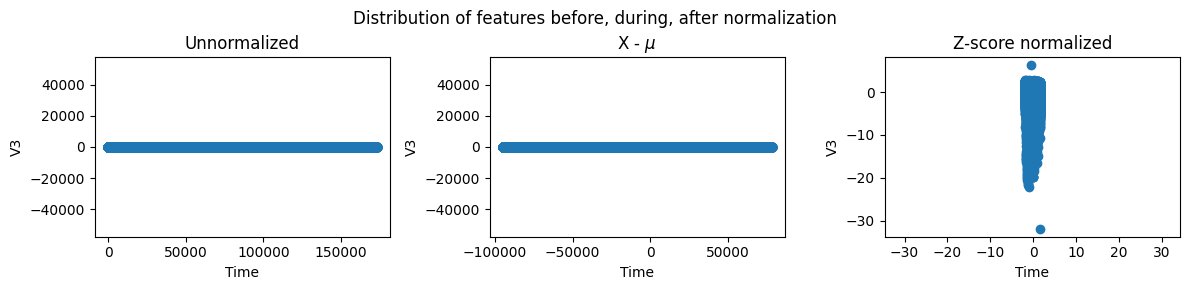

In [ ]:
def zscore_normalize_features(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return (X_norm, mu, sigma)

X = data.drop(columns=['Class']).values  # Convert to numpy array
X_norm, mu, sigma = zscore_normalize_features(X)

data_scaled = pd.DataFrame(X_norm, columns=data.columns[:-1])
data_scaled['Class'] = data['Class'].values  # Add class column back

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X[:,0], X[:,3])
ax[0].set_xlabel(data.columns[0]); ax[0].set_ylabel(data.columns[3]);
ax[0].set_title("Unnormalized")
ax[0].axis('equal')

ax[1].scatter((X - mu)[:,0], (X - mu)[:,3])
ax[1].set_xlabel(data.columns[0]); ax[1].set_ylabel(data.columns[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(data.columns[0]); ax[2].set_ylabel(data.columns[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Distribution of features before, during, after normalization")
plt.show()

#### **İlk grafik ham veriyi gösterir, ortanca grafik verinin ortalamasını alır ve son grafik ise Z-score normalizasyonu uygulanmış veriyi gösterir.**
1. İlk grafik:
* Verinin ölçeği büyük ve geniş bir aralıkta dağılmış.
2. Ortadaki grafik:
* Verinin ortalaması 0'a kaydırılmış.
3. Son grafik:
* Veri belirli bir aralıkta toplanmış.

## 2.3 Train-test Splitting Strategy
Eğitim seti, modeli eğitmek için kullanılan verilerdir ve test seti verileri (modele yeni olan) modelin performansını ve doğruluğunu test etmek için kullanılır.

In [8]:
features = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Amount']
X = data.loc[:, features]
y = data.loc[:, ['Class']]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

print(f"x_train: {x_train.shape}, x_test: {x_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")   #Sampling techniques

x_train: (227845, 30), x_test: (56962, 30), y_train: (227845, 1), y_test: (56962, 1)


* **X_train: (2277845, 30): Eğitim veri seti 2.277.8455 satır ve 30 sütundan oluşuyor.**
* **X_test: (56962, 30): Test veri seti 56.962 satır ve 30 sütundan oluşuyor.**

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# SMOTE ile veri dengeleme
smote = SMOTE(random_state=0)
x_train, y_train = smote.fit_resample(x_train, y_train)

# Dengelenmiş veri setinin boyutlarını yazdır
print(f"x_train_smote: {x_train.shape}, y_train_smote: {y_train.shape}")

x_train_smote: (454908, 30), y_train_smote: (454908, 1)


## 2.4 Cross-Validation
Modelin farklı veri bölümlerinde nasıl performans gösterdiğini değerlendirerek aşırı öğrenme (overfitting) ve eksik öğrenme (underfitting) gibi sorunları tespit etmeye yardımcı olur.

### K- Fold Yöntemi

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42) # Veri kümesi 10 eşit parçaya bölündü

for train_index, val_index in kf.split(x_train):
    x_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    print("Train fold:", train_index)
    print("Validation fold:", val_index)



Train fold: [     0      1      2 ... 454905 454906 454907]
Validation fold: [     6     26     30 ... 454874 454891 454897]
Train fold: [     0      1      2 ... 454903 454905 454906]
Validation fold: [    24     35     54 ... 454895 454904 454907]
Train fold: [     0      1      3 ... 454902 454904 454907]
Validation fold: [     2      7     11 ... 454903 454905 454906]
Train fold: [     1      2      3 ... 454905 454906 454907]
Validation fold: [     0     16     17 ... 454881 454885 454887]
Train fold: [     0      1      2 ... 454905 454906 454907]
Validation fold: [     4     12     20 ... 454894 454898 454899]
Train fold: [     0      1      2 ... 454905 454906 454907]
Validation fold: [    10     29     38 ... 454861 454872 454890]
Train fold: [     0      2      3 ... 454905 454906 454907]
Validation fold: [     1      8      9 ... 454870 454876 454888]
Train fold: [     0      1      2 ... 454905 454906 454907]
Validation fold: [     3     14     23 ... 454886 454893 454901]


Test Split Strategy ve Cross Validation gibi yöntemler overfitting sorunlarını önlemek için kullanılır.

Veri Seti Dengesizliği Neden Bir Sorun Olabilir?
* Dengesiz veri setleri üzerinde eğitilen veriler, genel hatayı en aza indirmek için çoğunluk sınıfını tercih etme eğilimindedir. Bu yüzden, çeşitli hatalara sebep olabilir.
* Dengesiz veri setleri, çoğunluk sınıfında aşırı uyuma yol açabilir ve modelin yeni, görülmemiş verilere genelleme yapma yeteneğini azaltabilir.

Veri Seti Dengesizliğini Aşma Yöntemleri
Yukarıda da yaptığımız missing value treatment,feature scaling,train-test splitting strategy, cross-validation gibi çeşitli yöntemlerle bu sorunlar aşılabilir.

In [ ]:
methods = {
    "Technique": [
        "Missing Value Treatment",
        "Feature Scaling",
        "Outlier Detection",
        "Train-Test Splitting",
        "Cross-Validation",
        "Oversampling (SMOTE)",
        "Undersampling",
        "Class Weight Adjustment",
        "Anomaly Detection"
    ],
    "Description": [
        "Eksik verileri doldurma veya kaldırma",
        "Verileri normalize etme veya standardize etme",
        "Aykırı değerleri tespit edip ele alma",
        "Veriyi eğitim ve test setlerine bölme",
        "Modelin genel performansını değerlendirme",
        "Azınlık sınıfından sentetik veri üretme",
        "Çoğunluk sınıfından bazı örnekleri kaldırma",
        "Azınlık sınıfına daha fazla ağırlık verme",
        "Fraud verilerini aykırı değer olarak tespit etme"
    ],
    "Advantages": [
        "Eksik verilerin model performansına etkisini azaltır",
        "Modelin daha iyi öğrenmesini sağlar",
        "Modelin yanlış tahmin yapmasını engeller",
        "Overfitting ve underfitting'i önler",
        "Modelin farklı veri kümelerinde tutarlı çalışmasını sağlar",
        "Daha fazla veri sağlar, azınlık sınıfını artırır",
        "Veriyi küçültüp işlem hızını artırır",
        "Ekstra veri gerektirmez, model ayarlamaları ile çözüm",
        "Çok az fraud verisi bile tespit edilebilir"
    ],
    "Disadvantages": [
        "Yanlış doldurma model hatalarına yol açabilir",
        "Yanlış ölçekleme, modelin performansını düşürebilir",
        "Aykırı değerlerin yanlış ele alınması bilgi kaybına neden olabilir",
        "Yanlış bölme modelin yanlış tahmin yapmasına neden olabilir",
        "Yanlış çapraz doğrulama, hatalı genelleştirmeye neden olabilir",
        "Yanlış sentetik veri üretimi, modelin doğruluğunu düşürebilir",
        "Veri kaybına yol açabilir, azınlık sınıfını küçültebilir",
        "Hassas model seçiminde başarısız olabilir",
        "Karmaşıklık artar, yanlış pozitif tahminler olabilir"
    ]
}

methods_df = pd.DataFrame(methods)
from IPython.display import display
display(methods_df)


,Technique,Description,Advantages,Disadvantages
0,Missing Value Treatment,Eksik verileri doldurma veya kaldırma,Eksik verilerin model performansına etkisini a...,Yanlış doldurma model hatalarına yol açabilir
1,Feature Scaling,Verileri normalize etme veya standardize etme,Modelin daha iyi öğrenmesini sağlar,"Yanlış ölçekleme, modelin performansını düşüre..."
2,Outlier Detection,Aykırı değerleri tespit edip ele alma,Modelin yanlış tahmin yapmasını engeller,Aykırı değerlerin yanlış ele alınması bilgi ka...
3,Train-Test Splitting,Veriyi eğitim ve test setlerine bölme,Overfitting ve underfitting'i önler,Yanlış bölme modelin yanlış tahmin yapmasına n...
4,Cross-Validation,Modelin genel performansını değerlendirme,Modelin farklı veri kümelerinde tutarlı çalışm...,"Yanlış çapraz doğrulama, hatalı genelleştirmey..."
5,Oversampling (SMOTE),Azınlık sınıfından sentetik veri üretme,"Daha fazla veri sağlar, azınlık sınıfını artırır","Yanlış sentetik veri üretimi, modelin doğruluğ..."
6,Undersampling,Çoğunluk sınıfından bazı örnekleri kaldırma,Veriyi küçültüp işlem hızını artırır,"Veri kaybına yol açabilir, azınlık sınıfını kü..."
7,Class Weight Adjustment,Azınlık sınıfına daha fazla ağırlık verme,"Ekstra veri gerektirmez, model ayarlamaları il...",Hassas model seçiminde başarısız olabilir
8,Anomaly Detection,Fraud verilerini aykırı değer olarak tespit etme,Çok az fraud verisi bile tespit edilebilir,"Karmaşıklık artar, yanlış pozitif tahminler ol..."


# 3. Data Analysis
1) Basic statistical analysis
2) Correlation analysis
3) Distribution analysis
4) Time-based patterns
5) Amount-based patterns
6) Feature importance analysis

## 3.1.Basic Static Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data.columns #Sütunların bilgisini içerir.

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
data.describe() # Sayısal sütunların istatistiklerini gösterir

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data.head() #İlk 5 satırı gösterir.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3.2 Correlation Analysis


**Correlation analysis, iki değişken arasındaki doğrusal ilişkiyi ölçer, -1 ile 1 arasında bir değer alır.1'e yakın değerlerde pozitif bir ilişki varken yani biri artarken diğeri de artar, -1 yakın değerlerde negatif bir ilişki vardır, 0'a yakın yerlerde ise doğrusal bir ilişki yoktur.**


In [ ]:
data.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


### Heatmap Gösterimi

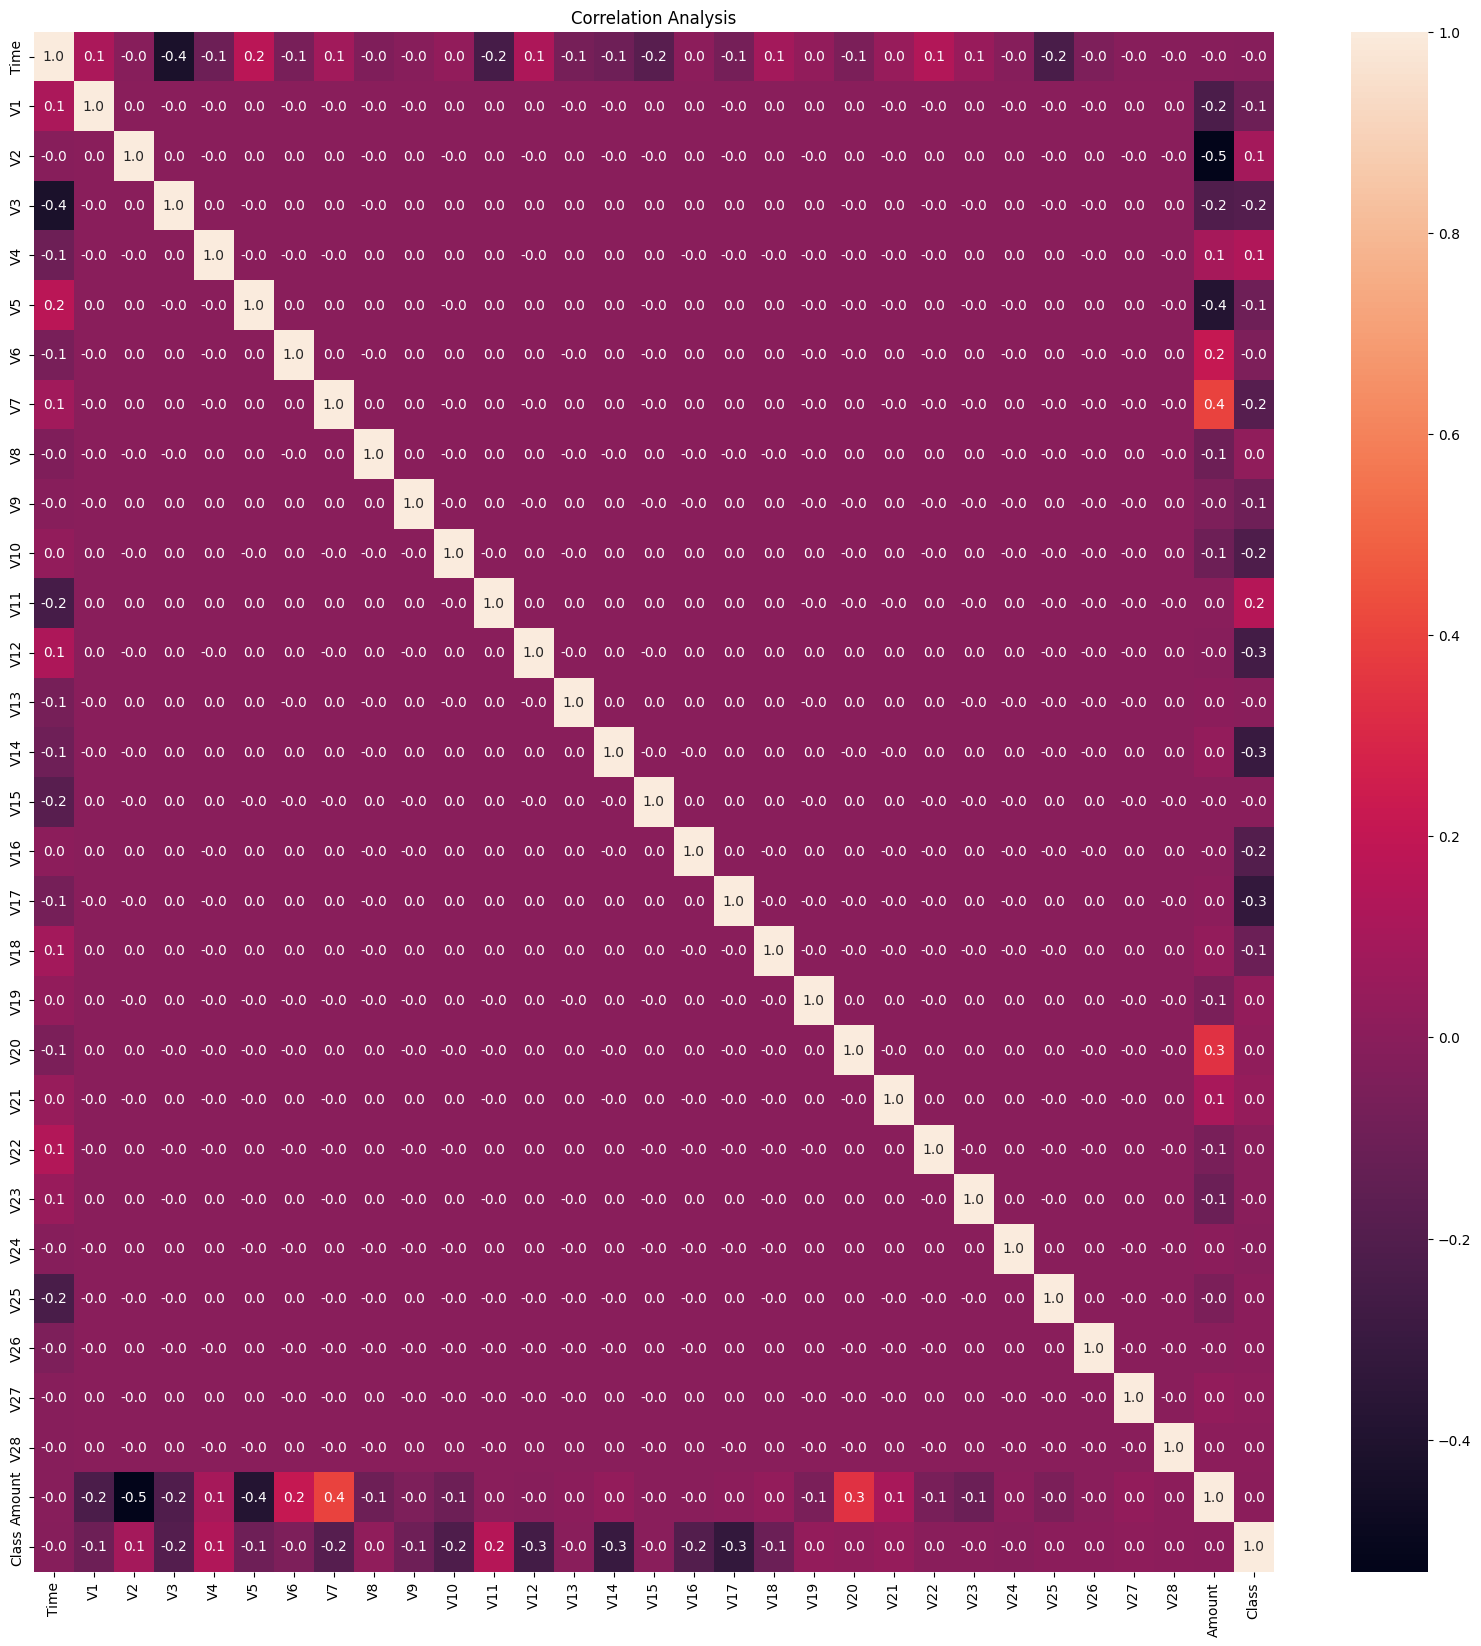

In [ ]:
plt.figure(figsize=(20, 20))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.1f')
plt.title('Correlation Analysis')
plt.show()

#### **Yukarıdaki grafiğe göre 1 değerine yakın olanlar birbiriyle iyi bir korelasyon içindeyken -0.5 değerine yaklaştıkça negatif bir korelasyona girerler.**

## 3.3 Distribution Analysis

In [ ]:
data['Class'].value_counts()   #Hedef class gösterildi. (1 dolandırıcılık işlemi, 0 dolandırıcılık dışı işlem)

,count
Class,
0,284315
1,492


### Histogram Grafiği ile Gösterme

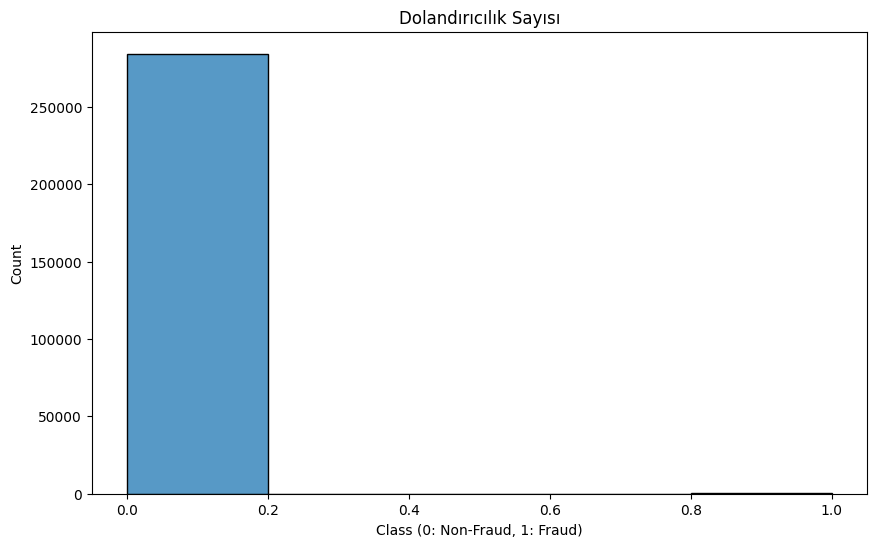

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x=data['Class'],bins=5)
plt.title("Dolandırıcılık Sayısı")
plt.xlabel("Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("Count")
plt.show()

### **Histogram grafiği ile dolandırıcılık sayısı 1 sayısına yakın olan kısımda görülmektedir**

## 3.4 Time-Based Patterns

### Histogram Grafiği ile Gösterme

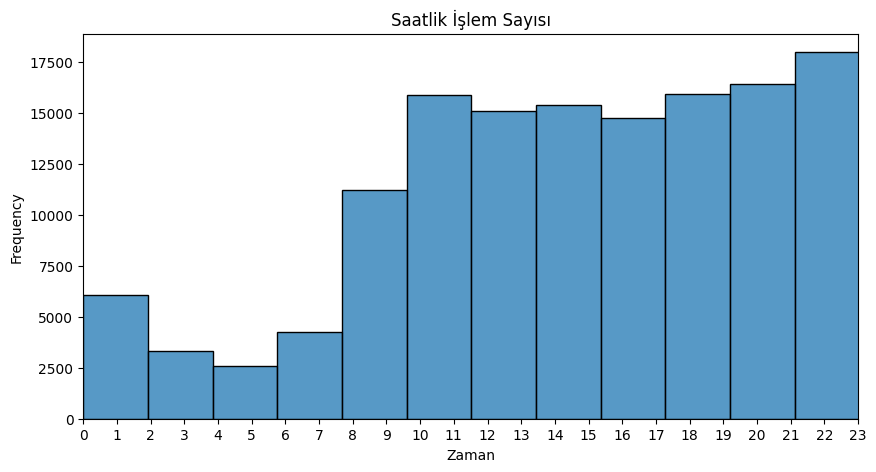

In [ ]:
plt.figure(figsize=(10, 5))
data['Time']=data['Time']/3600  # saniye saate çevrildi.
sns.histplot(data['Time'],bins=25, kde=False)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0,23)
plt.title('Saatlik İşlem Sayısı')
plt.xlabel('Zaman')
plt.ylabel('Frequency')
plt.show()

### **Histogram grafiği kullanarak 24 saat için işlem grafiği oluşturuldu.**

## 3.5 Amount-Based Patterns

### Boxplot ile Gösterim

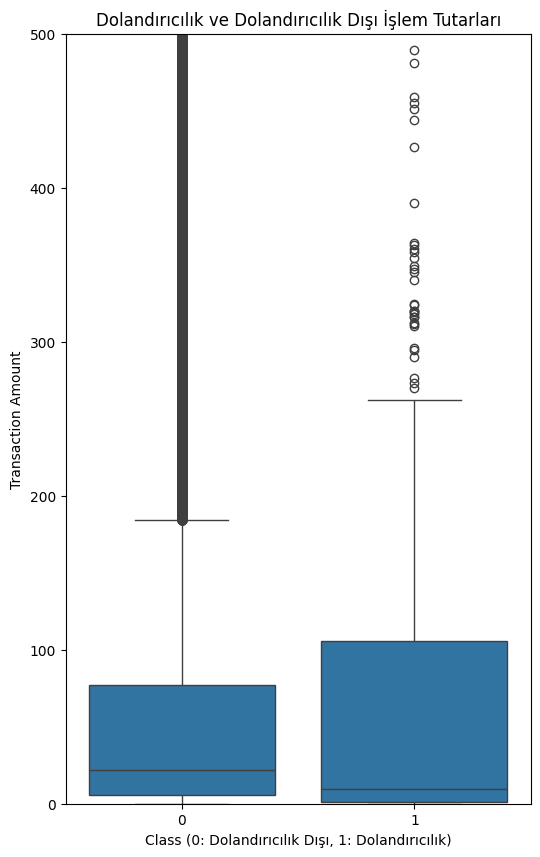

In [ ]:
plt.figure(figsize=(6, 10))
sns.boxplot(x=data['Class'], y=data['Amount'])
plt.ylim(0, 500)  # Aşırı büyük işlemleri hariç tutarak görselliği iyileştir
plt.title("Dolandırıcılık ve Dolandırıcılık Dışı İşlem Tutarları")
plt.xlabel("Class (0: Dolandırıcılık Dışı, 1: Dolandırıcılık)")
plt.ylabel("Transaction Amount")
plt.show()

#### **Dolandırıcılık işlemleri daha geniş işlem tutarına sahiptir. Dolandırıcılık dışı işlemlerde aykırı değerler daha dağınıktır.**

## 3.6 Feature Importance Analysis

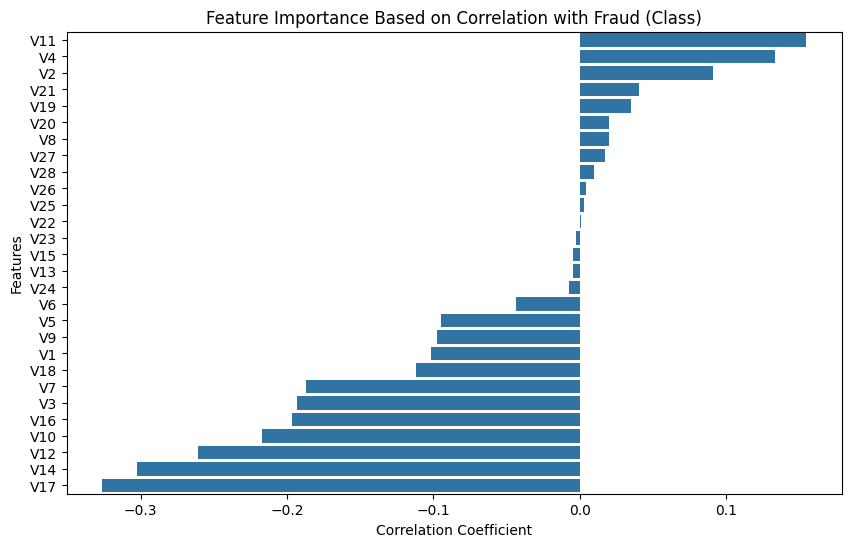

In [ ]:
corr_data= data.drop(columns=['Time', 'Amount'])
correlation_matrix = corr_data.corr()
feature_importance = correlation_matrix["Class"].sort_values(ascending=False)
top_features = feature_importance.index[1:]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[top_features].values, y=top_features)
plt.title("Feature Importance Based on Correlation with Fraud (Class)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

#### **Bu grafikte V11, V4, V2, V21 gibi değişkenler dolandırıcılık ile pozitif korelasyona sahip olduğu görülmektedir. V17, V14, V12, V10 gibi değişkenler ise dolandırıcılıkla negatif korelasyon gösteriyor.**



## 3.7 Violin Plot Yöntemi Class Yoğunluklarının Gösterimi

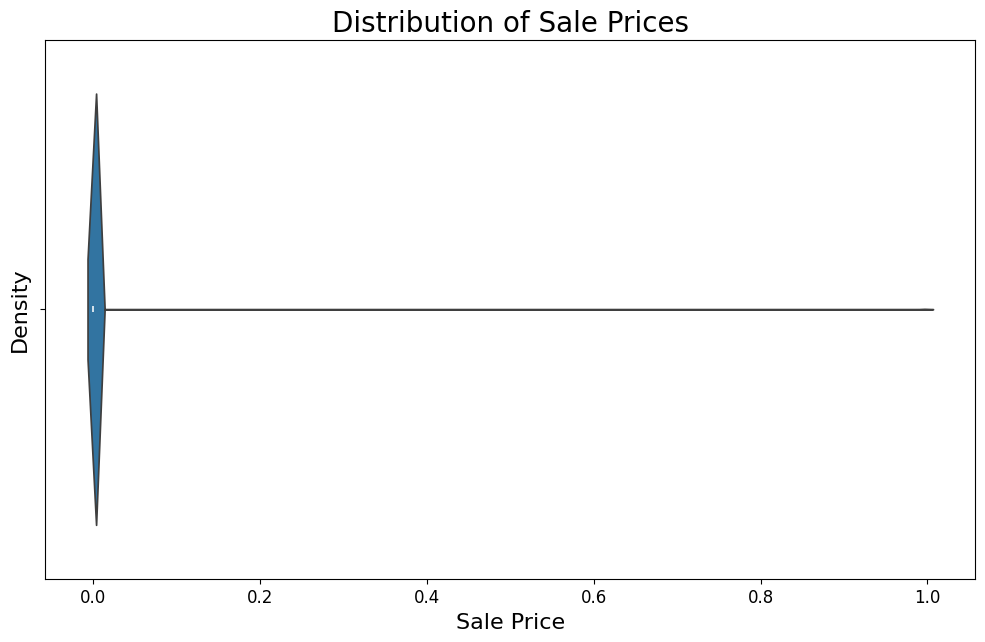

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.violinplot(data=data, x='Class')
ax.set_title('Distribution of Sale Prices', fontsize=20)
ax.set_xlabel('Sale Price', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

## 3.8 Pie Chart Yöntemi ile Gösterim

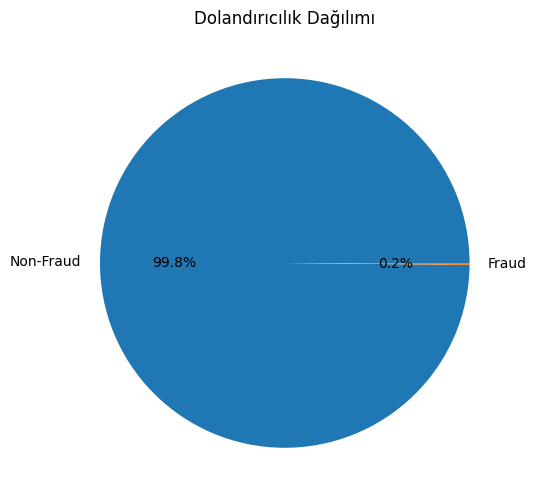

In [ ]:
datanew = data['Class'].value_counts()
labels = ['Non-Fraud', 'Fraud']
colors = ['lightblue', 'red']
plt.figure(figsize=(6, 6))
plt.pie(datanew, labels=labels, autopct='%1.1f%%')
plt.title("Dolandırıcılık Dağılımı")
plt.show()


### **Hem violin plot yönteminde hem de pie chart yönteminde class yoğunlukları gösterildi.**

# **4. Training**

## 4.1 Supervised Learning
   #### Etiketli veriler kullanılarak eğitilir, yani giriş verileri doğru çıktıyla etiketlenir. Bu algoritmaların amacı, girdilerden çıktılara bir eşleme öğrenmek ve böylece yeni veriler için çıktıyı tahmin etmektir.

## 4.1.1 Lineer Regression

In [79]:
model = LinearRegression()
model.fit(x_train, y_train)

print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_}")

Intercept: [0.21775531]
Coefficient: [[-7.06442478e-07 -1.54513532e-02  2.35526845e-03 -1.55320076e-02
   5.37419849e-02  1.00176893e-02 -1.22696158e-02  2.32385693e-02
  -1.31562318e-02  9.78129725e-03 -1.84028116e-02 -6.13616910e-03
   1.43091088e-02 -2.77125835e-02 -6.38527122e-02 -1.15370153e-02
   1.20580477e-02 -1.18758380e-02  3.10287067e-02  1.48733724e-02
   1.17148177e-02  1.18911451e-02  3.94184833e-02 -1.85089517e-02
  -9.03051896e-03 -2.63457220e-02 -5.35190070e-02  1.56004915e-02
   4.69314971e-02  3.29892980e-05]]


In [80]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)


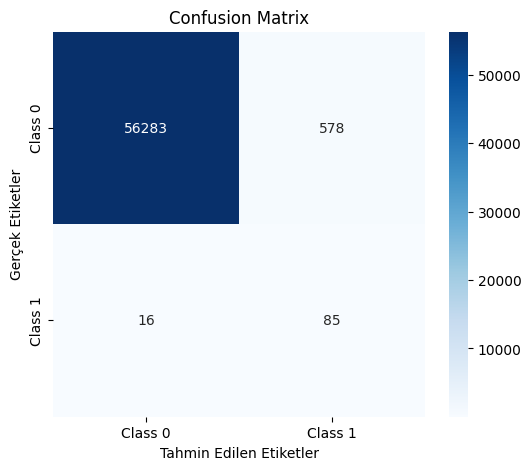

In [81]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.show()


Verilen çıktıya göre, çoğunlukla Class 0 üzerinde çok doğru tahminler yapmış, ancak Class 1  üzerinde bazı hatalar yapmış.
 Class 0 için doğru tahmin oranı çok yüksek, ancak Class 1'de yanlış sınıflandırmalar daha fazla olmuş.
 Özellikle 85 false positive ve 16 false negative değeri, modelin Class 1'i doğru tahmin etmede zorlandığını gösteriyor.
 Genel olarak doğruluk oranı yüksek ama Class 1 için modeli iyileştirmek gerekebilir.

## 4.1.2 Logistic Regression

* Verinin belirli bir sınıfa ait olup olmadığını tahmin etmek olduğu
sınıflandırma görevleri için kullanılan bir gözetimli makine öğrenme algoritmasıdır.

* Lojistik regresyon , girdileri bağımsız değişkenler olarak alan ve 0 ile 1 arasında bir olasılık değeri üreten sigmoid fonksiyonunu için kullanılan ikili sınıflandırma için kullanılır .

In [ ]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(x_train, y_train.values.ravel())

y_pred = logreg.predict(x_test)

acc = accuracy_score(y_test, y_pred) * 100
print(f"Logistic Regression Accuracy: {acc:.2f}%")


Logistic Regression Accuracy: 99.06%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


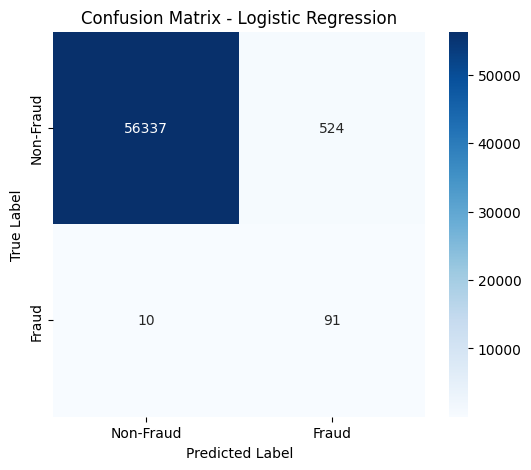

In [ ]:
y_pred = logreg.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


##### **Linear Regression ile Logistic Regression Arasındaki Fark**
Doğrusal Regresyon sürekli sonuçları tahmin etmek için kullanılırken, Lojistik Regresyon bir gözlemin belirli bir kategoriye girme olasılığını tahmin etmek için kullanılır. Lojistik Regresyon, tahmin edilen değerleri 0 ile 1 arasında eşleştirmek için S şeklinde bir lojistik fonksiyon kullanır.



## 4.1.3 Decision Tree
#### Karar ağacı, bir problemi çözmek için farklı seçeneklerin grafiksel bir gösterimidir ve farklı faktörlerin nasıl ilişkili olduğunu gösterir.

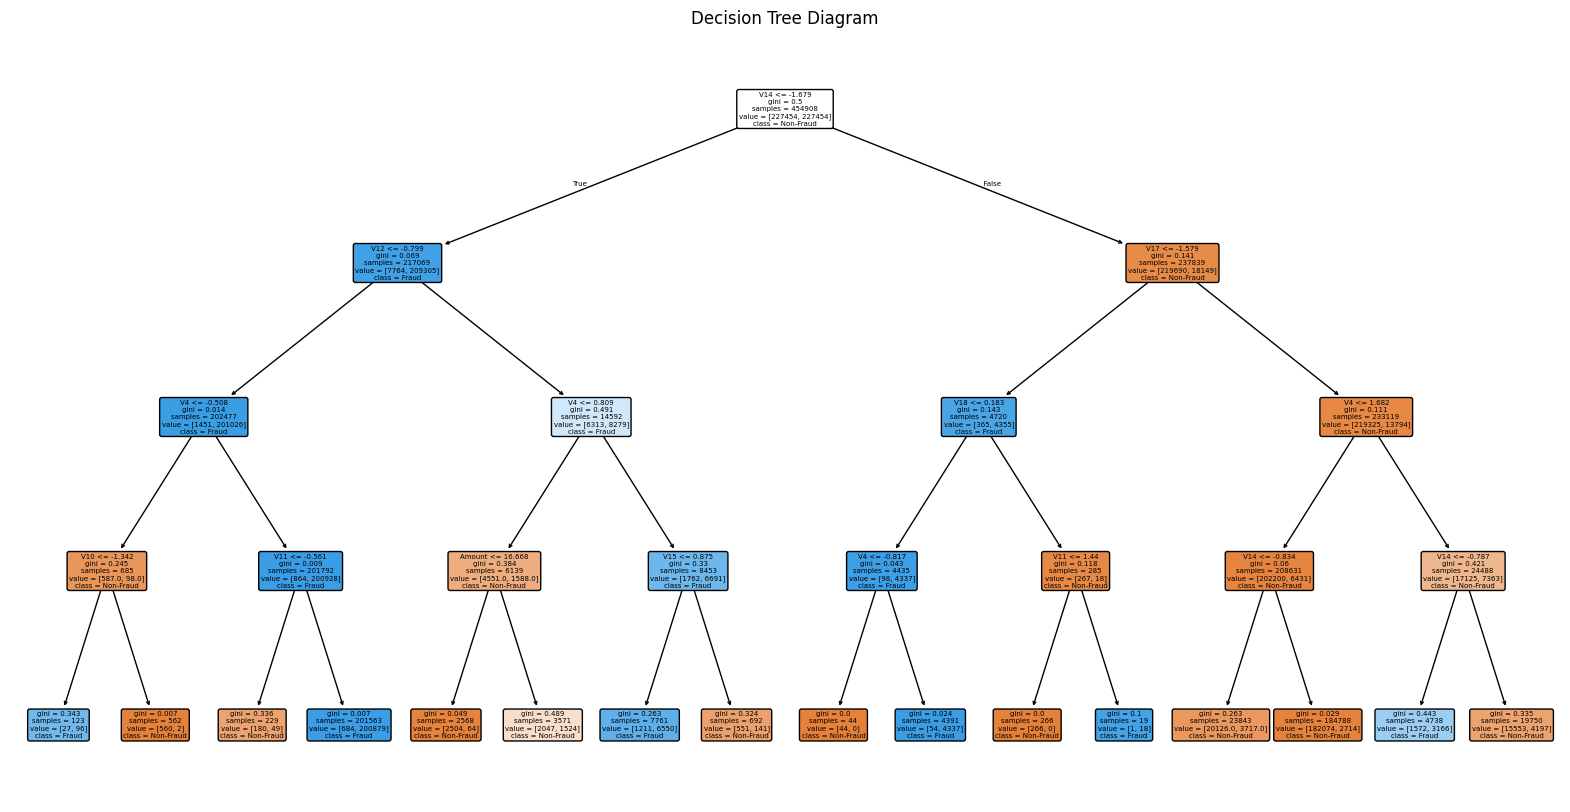

In [ ]:
dt_model = DecisionTreeClassifier(random_state=0, max_depth=4)
dt_model.fit(x_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=x_train.columns, class_names=["Non-Fraud", "Fraud"], filled=True, rounded=True)
plt.title("Decision Tree Diagram")
plt.show()
#gini: düğümdeki veri karışıklığını ifade eder.

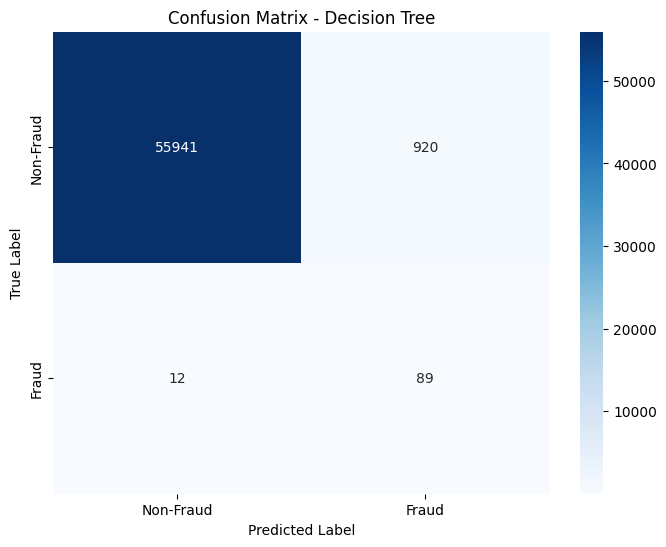

In [ ]:
y_pred = dt_model.predict(x_test)

# Confusion matrix oluştur
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### * Kredi kartı dolandırıcılığı tespitinde hangi özelliklerin (V17, V10, V14, V26, vb.) daha belirleyici olduğunu gösteriyor.
#### * Mavi düğümler dolandırıcılık işlemlerini (Fraud), turuncu düğümler ise normal işlemleri (Non-Fraud) temsil eder. Derin dallar, modelin fazla öğrenmiş (overfitting) olabileceğini gösterebilir.

## 4.1.4 Random Forest Algorithm
Makine Öğrenmesinde tahminler yapmak için güçlü bir ağaç öğrenme tekniğidir ve daha sonra tahmin yapmak için tüm ağaçların oylamasını yapılır . Sınıflandırma ve regresyon görevi için yaygın olarak kullanılırlar.

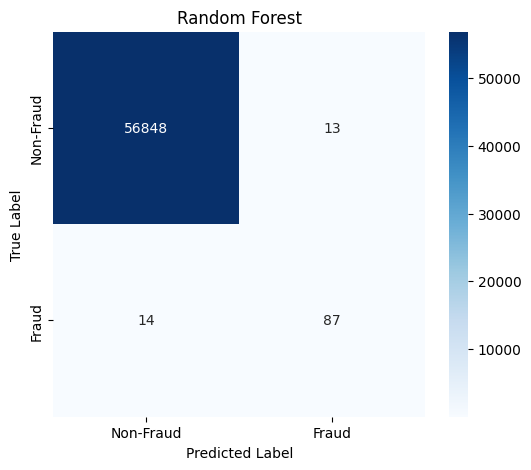

In [12]:
np.random.seed(42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train.values.ravel())

y_ran = rf.predict(x_test)

cm = confusion_matrix(y_test, y_ran)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest")
plt.show()

## 4.1.5 Support Vector Machines (SVM)
Temel amacı, veri noktalarını en iyi şekilde ayıran bir karar sınırı (hyperplane) bulmaktır.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Doğruluğu: 0.9831

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.09      0.89      0.16       101

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962



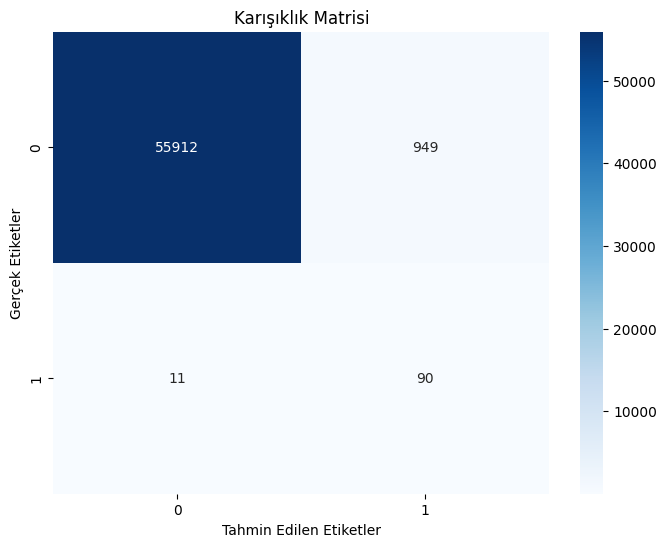

Karar sınırları sadece 2 boyutlu veriler için görselleştirilebilir.


In [20]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
"""
# Verileri ölçeklendir
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
"""
# Modeli oluştur ve eğit
# Daha hızlı bir alternatif olarak LinearSVC kullanabilirsiniz
svm_model = LinearSVC(max_iter=10000)  # max_iter ile iterasyon sayısını artırabilirsiniz
svm_model.fit(x_train, y_train)

# Tahmin yap
y_pred = svm_model.predict(x_test)

# Model performansını değerlendir
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.4f}")

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Karışıklık matrisini görselleştir
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Karışıklık Matrisi')
plt.show()

# Karar sınırlarını görselleştir (2 boyutlu veriler için)
if x_train.shape[1] == 2:  # Sadece 2 özellik varsa görselleştir
    plt.figure(figsize=(10, 8))

    # Eğitim verisini çiz
    plt.scatter(x_train_scaled[:, 0], x_train_scaled[:, 1], c=y_train, cmap='coolwarm', s=50, edgecolors='k', label='Eğitim Verisi')

    # Test verisini çiz
    plt.scatter(x_test_scaled[:, 0], x_test_scaled[:, 1], c=y_test, cmap='coolwarm', s=100, marker='x', label='Test Verisi')

    # Karar sınırlarını çiz
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Karar sınırını oluşturmak için grid oluştur
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = svm_model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Karar sınırlarını ve marjini çiz
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z, colors='k', linestyles='--', linewidths=1)

    plt.xlabel('Özellik 1')
    plt.ylabel('Özellik 2')
    plt.title('SVM Karar Sınırları')
    plt.legend()
    plt.show()
else:
    print("Karar sınırları sadece 2 boyutlu veriler için görselleştirilebilir.")

## 4.1.6 XGBoost

In [22]:
import xgboost as xgb

X_train_new = x_train.drop(columns=['Time', 'Amount'])
X_test_new = x_test.drop(columns=['Time', 'Amount'])

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_new, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test_new)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Doğruluğu: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:12:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Doğruluğu: 0.9984


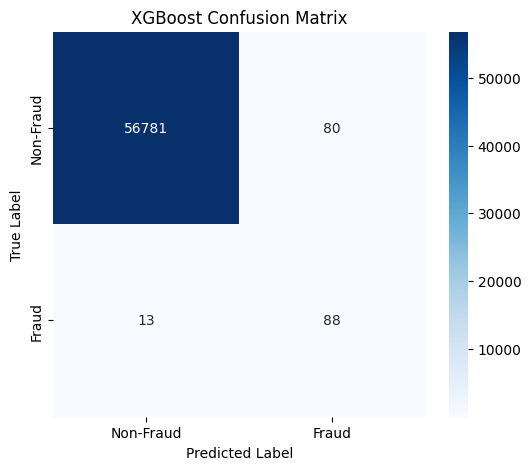

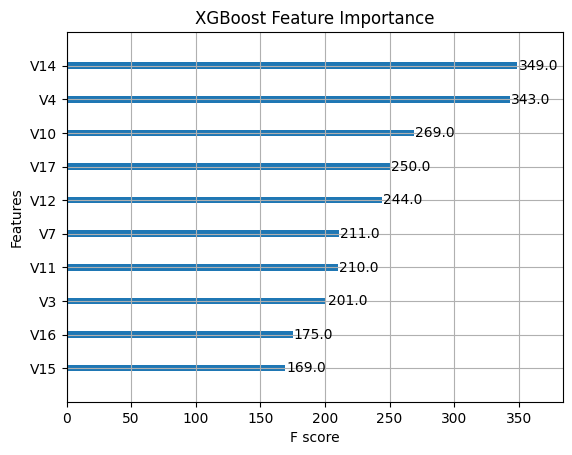

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Feature importance plot
xgb.plot_importance(xgb_model, max_num_features=10, importance_type="weight")
plt.title("XGBoost Feature Importance")
plt.show()

 * 56,855 Normal İşlem (Non-Fraud) doğru tahmin edildi.
 * 82 Fraud İşlem doğru tahmin edildi (model bunları yakalayabildi).
 * 19 Fraud İşlem yanlış tahmin edildi (Model bunları fraud olarak algılamadı – hatalı negatif).
 * 6 Normal İşlem hatalı olarak fraud tahmin edildi (hatalı pozitif – yanlış alarm).

# 4.1.7 K-Nearest Neighbors (KNN)

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline


kf = KFold(n_splits=3, shuffle=True, random_state=0)  # K-Fold
model = KNeighborsClassifier(n_neighbors=2)  # KNN modeli

pipeline = make_pipeline(StandardScaler(), model)

accuracies = cross_val_score(pipeline, X, y, cv=kf, n_jobs=-1)  # n_jobs=-1 tüm çekirdekleri kullanır

for accuracy in accuracies:
    print(f"Accuracy: {accuracy:.4f}")

print(f"Average Accuracy: {np.mean(accuracies):.4f}")

Accuracy: 0.9995
Accuracy: 0.9995
Accuracy: 0.9995
Average Accuracy: 0.9995


# 4.2 Unsupervised Learning
* Etiketli veri yoktur. Model, yalnızca girdilerle çalışır ve kendi içinde gruplamalar yapar.
* Genellikle büyük ve karmaşık veri setlerinde kullanılır.
* Önceden tanımlanmış bir doğru-yanlış ölçütü yoktur, model veri içindeki benzerlikleri ve yapıları bulmaya çalışır.

## 4.2.1 Principal Component Analysis (PCA)
#### Mümkün olduğunca fazla bilgiyi korurken, bir veri kümesindeki değişken sayısını azaltmak için kullanılır.

Explained variance ratio (Her bir bileşenin açıkladığı varyans oranı): [0.06527521 0.05612313]
Toplam açıklanan varyans: 0.12139834577465444


<ipython-input-100-fe4377805480>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, cmap='viridis')  # 2 boyutlu PCA sonuçlarını çiz


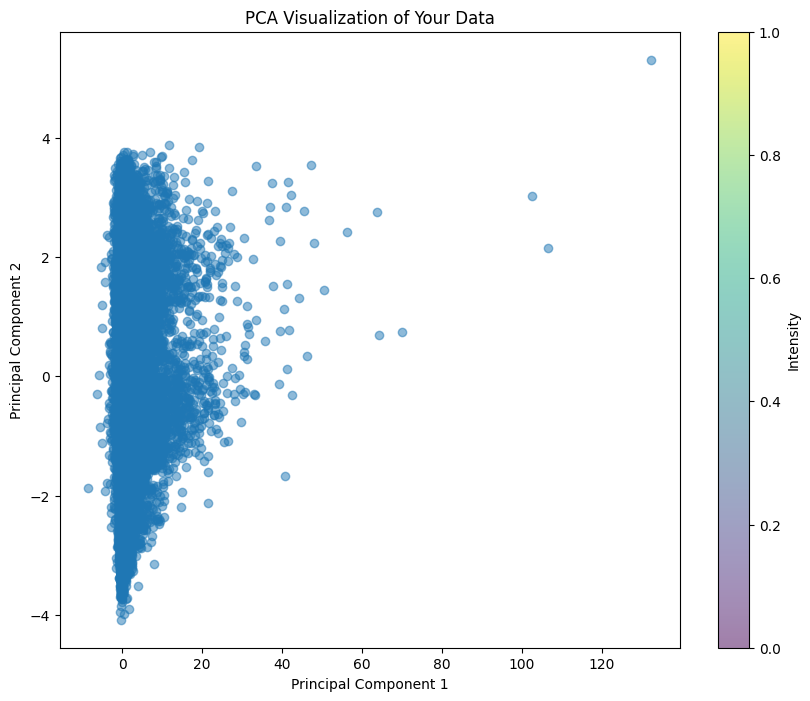

In [100]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop(columns=['Class']))
pca = PCA(n_components=2)  # 2 boyut için PCA
X_pca = pca.fit_transform(X_scaled)  # Ölçeklendirilmiş verileri 2 boyuta indirge

# Açıklanan varyans oranı
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio (Her bir bileşenin açıkladığı varyans oranı):", explained_variance)
print("Toplam açıklanan varyans:", np.sum(explained_variance))

# PCA sonuçlarını scatter plot ile görselleştir
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, cmap='viridis')  # 2 boyutlu PCA sonuçlarını çiz
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Your Data")
plt.colorbar(scatter, label='Intensity')  # Renk skalası için colorbar ekle
plt.show()

Noktaların renkleri, veri noktalarının yoğunluğunu veya başka bir özelliğini temsil ediyor.

Açıklanan varyans oranları, ilk iki temel bileşenin verideki toplam varyansın %12.14'ünü açıkladığını gösteriyor. Bu, veri setinin önemli özelliklerinin büyük ölçüde bu iki temel bileşen tarafından temsil edildiğini ifade ediyor.

Böyle PCA yöntemi, yüksek boyutlu verilerin daha anlaşılır bir şekilde incelenmesine olanak tanıyor.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


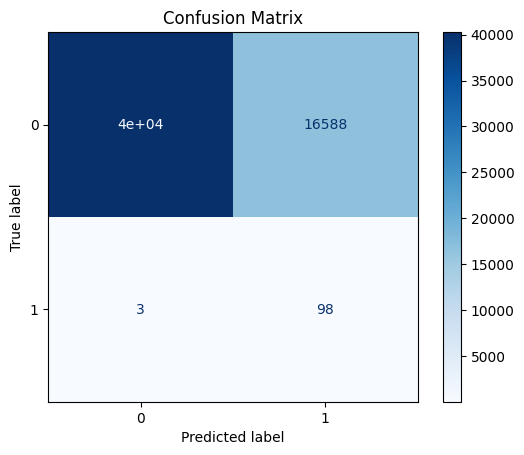

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

pca = PCA(n_components=2)  # 2 boyut için PCA
X_pca = pca.fit_transform(X_scaled)

# Lojistik Regresyon modelini oluştur ve eğit
model = LogisticRegression()
model.fit(x_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Karışıklık matrisini hesapla
cm = confusion_matrix(y_test, y_pred)

# Karışıklık matrisini görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## 4.2.2 Clustering

### K - Means Clustering
Verileri benzerliklerine göre gruplara ayırmak için kullanılan bir tekniktir . Önce bazı merkez noktaları seçerek her veri en yakın merkeze atanmasıyla çalışır. Tüm noktalar bir kümeye atandıktan sonra, merkezler her kümedeki noktaların ortalama konumu bulunarak güncellenir. Bu işlem, merkezler kümeler oluşturmayı bırakana kadar tekrarlanır.

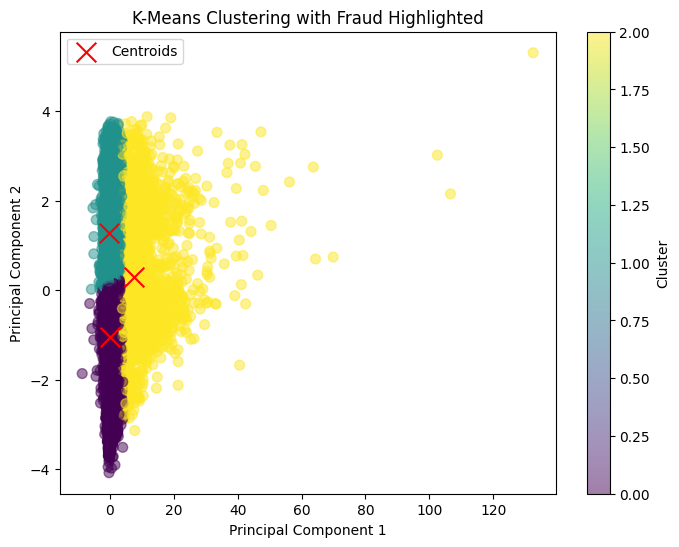

In [53]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

labels = kmeans.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.colorbar(scatter, label="Cluster")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering with Fraud Highlighted")
plt.legend()
plt.show()

V1, V2 gibi 3 verinin kümeleme algoritmasıyla Fraud oranıdır.

### Hierarchical Clustering

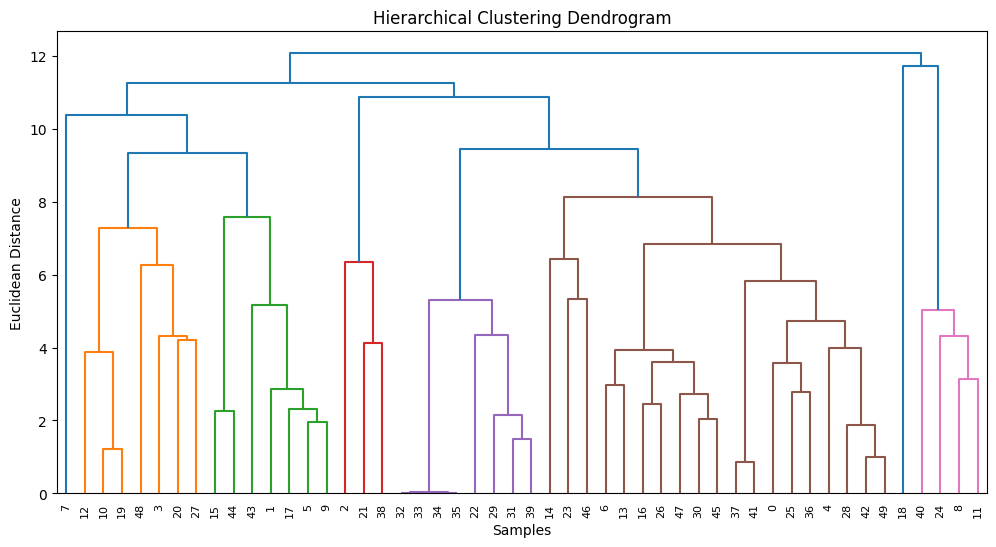

In [54]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled[:50], method='ward')) #veri setinin ilk 50 özelliğini alındı.
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()


Samples verideki V7, V12 gibi ifade eder. Mesafe ise verilerin birbirinden uzaklığını temsil eder.  Düşük mesafeler benzer örnekleri, yüksek mesafeler ise farklı örnekleri temsil ediyor.

## 5. Score Puanlarına Göre Değerlendirme

### **Logistic Regression Score**

In [5]:
model = LogisticRegression(max_iter=5000)
results = []

model.fit(x_train, y_train)
y_pred = model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Çok sınıflı veriler için
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append({ "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)

# Grafik çizme
print(f1)

0.27993779160186627


### **Desicion Tree Score**

In [14]:
model2=DecisionTreeClassifier(random_state=42)
results = []

model2.fit(x_train, y_train)
y_pred = model2.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Çok sınıflı veriler için
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append({ "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)

# Grafik çizme
print(f1)

0.014388489208633094


### **K-Means Clustering SCORE**

In [102]:
model3=KMeans(n_clusters=3, random_state=42)
model3.fit(x_train, y_train)
y_pred = model3.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # For multi-class data
recall = recall_score(y_test, y_pred, average='weighted')  # For multi-class data
f1 = f1_score(y_test, y_pred, average='weighted')  # For multi-class data

# Append results to the list
results.append({
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   Accuracy  Precision    Recall  F1 Score
0   0.99519   0.011299  0.019802  0.014388
1   0.99519   0.011299  0.019802  0.014388
2   0.00000   0.000000  0.000000  0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Linear Regression Score**

In [106]:
model4 = LinearRegression()
model4.fit(x_train, y_train)
y_pred = model4.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Append results to the list
results.append({
    "Mean Squared Error": mse,
    "Mean Absolute Error": mae,
    "R2 Score": r2
})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   Accuracy  Precision    Recall  F1 Score  Mean Squared Error  \
0   0.99519   0.011299  0.019802  0.014388                 NaN   
1   0.99519   0.011299  0.019802  0.014388                 NaN   
2   0.00000   0.000000  0.000000  0.000000                 NaN   
3       NaN        NaN       NaN       NaN            3.994681   
4       NaN        NaN       NaN       NaN            0.066882   

   Mean Absolute Error     R2 Score  
0                  NaN          NaN  
1                  NaN          NaN  
2                  NaN          NaN  
3             1.998227 -2255.922568  
4             0.223404   -36.787306  


### **XGBBoost Score**

In [16]:
import xgboost as xgb

model7=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model7.fit(x_train, y_train)
y_pred = model7.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Çok sınıflı veriler için
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append({ "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)

# Grafik çizme
print(f1)

0.7058823529411765


### **Random Forest Algorithm Score**

In [23]:
model8=RandomForestClassifier(n_estimators=100, random_state=42)
model8.fit(x_train, y_train)
y_pred = model8.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Çok sınıflı veriler için
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append({ "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)

# Grafik çizme
print(f1)

0.783625730994152


### **SVM Score**

In [19]:
from sklearn.svm import SVC, LinearSVC

model5=LinearSVC(max_iter=10000)
model5.fit(x_train, y_train)
y_pred = model5.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Çok sınıflı veriler için
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append({ "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)

# Grafik çizme
print(f1)

0.013700545225779393


### **KNN Score**

In [21]:
model6=KFold(n_splits=3, shuffle=True, random_state=0)
model5.fit(x_train, y_train)
y_pred = model5.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Çok sınıflı veriler için
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append({ "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)

# Grafik çizme
print(f1)

0.013700545225779393


# **Sonuç**

### F1 Score yöntemiyle ML algoritmalarını test ettiğimizde Random Forest yönteminin en yüksek olduğu görülüyor. O yüzden veri için bu yöntemi kullanmak doğru seçenek olacaktır.